## COVID Global Forecast: SIR model + ML regressions

In the context of the global COVID-19 pandemic, Kaggle has launched several challenges in order to provide useful insights that may answer some of the open scientific questions about the virus. This is the case of the COVID19 Global Forecasting, in which participants are encouraged to fit worldwide data in order to predict the pandemic evolution, hopefully helping to determine which factors impact the transmission behavior of COVID-19.

Disclaimer 1: this notebook is being updated frequently with the objective of improving predictions by using new models.

Disclaimer 2: the training dataset is also updated on a daily basis in order to include the most recent cases. In order to be up to date and prevent data leaking and other potential problems, daily updates on "filtered dates" will be applied.

Disclaimer 3: the COVID Global Forecasting competition is updated week by week (with a new competition). I'll move the notebook from previous weeks to the new one, so that it only appears in the most recent competition.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
from scipy import integrate, optimize
import warnings
warnings.filterwarnings('ignore')

# ML libraries
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

### 1. Exploratory data analysis (EDA) 

First of all, let's take a look on the data structure:


In [2]:
# submission_example = pd.read_csv("../input/covid19-global-forecasting-week-4/submission.csv")
# test = pd.read_csv("../input/covid19-global-forecasting-week-4/test.csv")
# train = pd.read_csv("../input/covid19-global-forecasting-week-4/train.csv")

submission_example = pd.read_csv("submission.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

train.Province_State.fillna("None", inplace=True)
display(train.head(5))
display(train.describe())
print("Number of Country_Region: ", train['Country_Region'].nunique())
print("Dates go from day", max(train['Date']), "to day", min(train['Date']), ", a total of", train['Date'].nunique(), "days")
print("Countries with Province/State informed: ", train.loc[train['Province_State']!='None']['Country_Region'].unique())

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,None,Afghanistan,2020-01-22,0.0,0.0
1,2,None,Afghanistan,2020-01-23,0.0,0.0
2,3,None,Afghanistan,2020-01-24,0.0,0.0
3,4,None,Afghanistan,2020-01-25,0.0,0.0
4,5,None,Afghanistan,2020-01-26,0.0,0.0


,Id,ConfirmedCases,Fatalities
count,28796.000000,28796.000000,28796.000000
mean,17830.500000,1727.536984,101.523232
std,10300.666674,11261.712561,1001.590412
min,1.000000,0.000000,0.000000
25%,8915.750000,0.000000,0.000000
50%,17830.500000,3.000000,0.000000
75%,26745.250000,183.000000,2.000000
max,35660.000000,263292.000000,25085.000000


Number of Country_Region:  184
Dates go from day 2020-04-22 to day 2020-01-22 , a total of 92 days
Countries with Province/State informed:  ['Australia' 'Canada' 'China' 'Denmark' 'France' 'Netherlands' 'US'
 'United Kingdom']


The dataset covers 163 countries and almost 2 full months from 2020, which is enough data to get some clues about the pandemic. Let's see a few plots of the worldwide tendency to see if we can extract some insights:

Text(0.5, 0, 'Date')

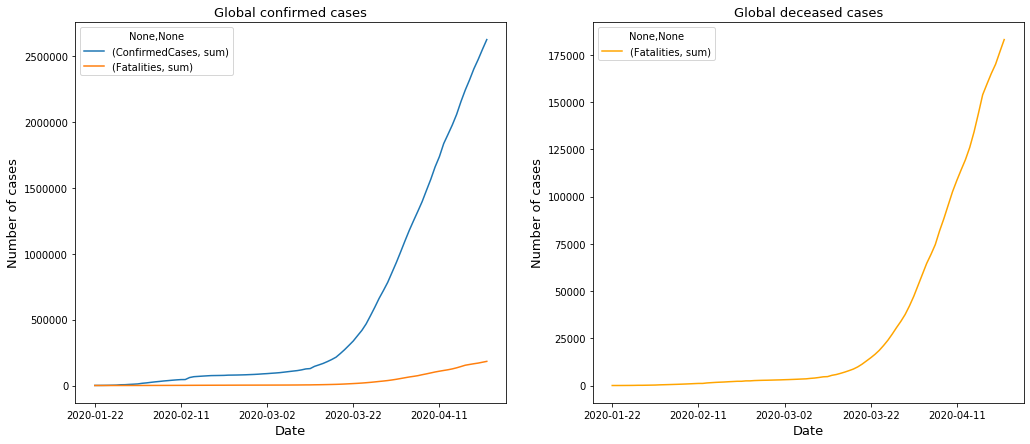

In [3]:
#confirmed_country = train.groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
#fatalities_country = train.groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date = train.groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date = train.groupby(['Date']).agg({'Fatalities':['sum']})
total_date = confirmed_total_date.join(fatalities_total_date)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date.plot(ax=ax1)
ax1.set_title("Global confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

Observations: The global curve shows a rich fine structure, but these numbers are strongly affected by the vector zero country, China. Given that COVID-19 started there, during the initial expansion of the virus there was no reliable information about the real infected cases. In fact, the criteria to consider infection cases was modified around 2020-02-11, which strongly perturbed the curve as you can see from the figure.

#### 1.1. COVID-19 global tendency excluding China

Since details of the initial breakthrough strongly interfere with the results, it's recomended to analyze China independently. Let's first see the results without China:

Text(0.5, 0, 'Date')

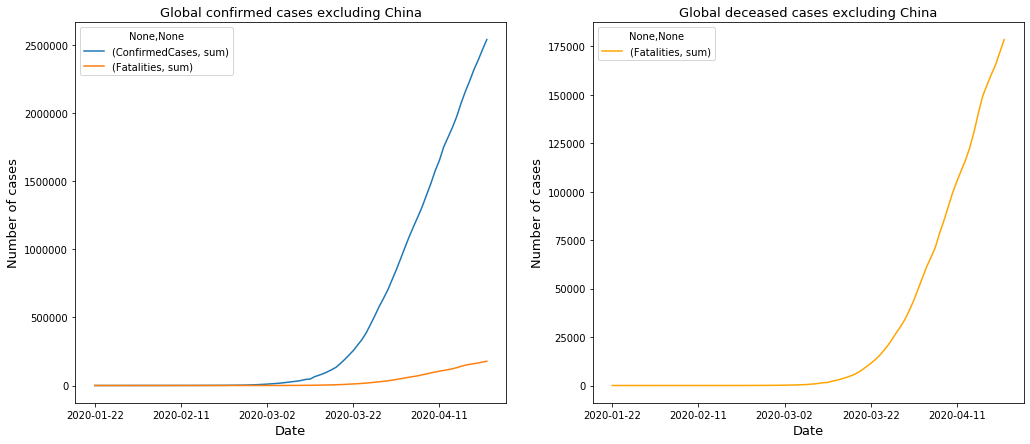

In [4]:
#confirmed_country_noChina = train[train['Country_Region']!='China'].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_noChina = train[train['Country_Region']!='China'].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_noChina = train[train['Country_Region']!='China'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_noChina = train[train['Country_Region']!='China'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_noChina = confirmed_total_date_noChina.join(fatalities_total_date_noChina)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date_noChina.plot(ax=ax1)
ax1.set_title("Global confirmed cases excluding China", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date_noChina.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases excluding China", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

Observations: In this case the general behavior looks cleaner, and in fact the curve resembles a typical epidemiology model like SIR. SIR models present a large increasing in the number of infections that, once it reaches the maximum of the contagion, decreases with a lower slope. For comparison, a SIR simulation from section 2. SIR model:

#### 1.2. COVID-19 tendency in China 

Since China was the initial infected country, the COVID-19 behavior is different from the rest of the world. The medical system was not prepared for the pandemic, in fact no one was aware of the virus until several cases were reported. Moreover, China government took strong contention measures in a considerable short period of time and, while the virus is widely spread, they have been able to control the increasing of the infections.

Text(0.5, 0, 'Date')

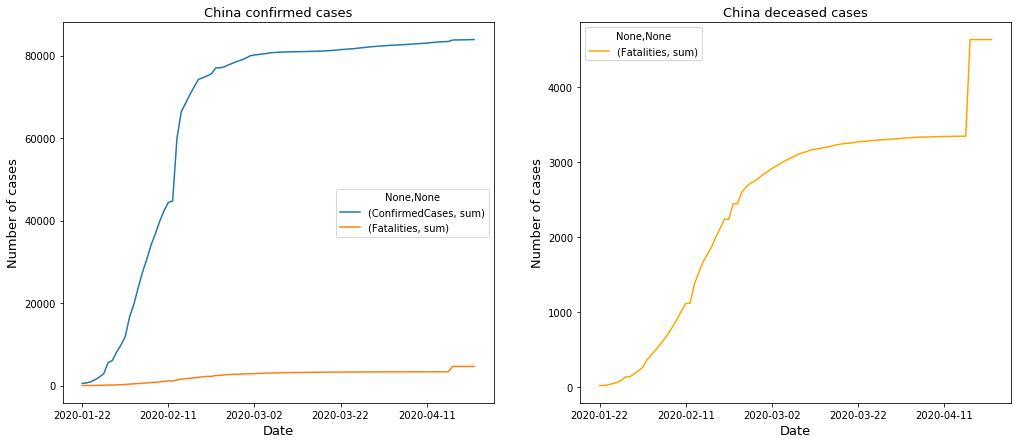

In [5]:
#confirmed_country_China = train[train['Country_Region']=='China'].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_China = train[train['Country_Region']=='China'].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_China = train[train['Country_Region']=='China'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_China = train[train['Country_Region']=='China'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_China = confirmed_total_date_China.join(fatalities_total_date_China)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date_China.plot(ax=ax1)
ax1.set_title("China confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date_China.plot(ax=ax2, color='orange')
ax2.set_title("China deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

Observations:

Smoothness. Both plots are less smooth than theoretical simulations or the curve from the rest of the world cumulative
Infected criteria. The moment in which the criteria to consider an infected case was changed is direclty spotted
Irregularities. There are some iregularities. I should check the literature in depth to look for evidences, but the reasons may be that both the resources spent to monitor the epidemy and the security measures to stop ot have been changing over time
Plateaux. It looks like the curve has reached a plateaux, which would imply that China is on their maximum of contagion

In [6]:
ee

NameError: name 'ee' is not defined

In [7]:
population = float(46750238)
country_df = pd.DataFrame()

In [13]:
train['Country_Region']=='Spain'

0        False
1        False
2        False
3        False
4        False
         ...  
28791    False
28792    False
28793    False
28794    False
28795    False
Name: Country_Region, Length: 28796, dtype: bool

In [98]:
train.loc[train['Country_Region']=='Spain'].head(11)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
20424,25309,None,Spain,2020-01-22,0.0,0.0
20425,25310,None,Spain,2020-01-23,0.0,0.0
20426,25311,None,Spain,2020-01-24,0.0,0.0
20427,25312,None,Spain,2020-01-25,0.0,0.0
20428,25313,None,Spain,2020-01-26,0.0,0.0
20429,25314,None,Spain,2020-01-27,0.0,0.0
20430,25315,None,Spain,2020-01-28,0.0,0.0
20431,25316,None,Spain,2020-01-29,0.0,0.0
20432,25317,None,Spain,2020-01-30,0.0,0.0
20433,25318,None,Spain,2020-01-31,0.0,0.0


In [15]:
train.loc[train['Country_Region']=='Spain'].ConfirmedCases.diff()

20424       NaN
20425       0.0
20426       0.0
20427       0.0
20428       0.0
          ...  
20511     887.0
20512    6948.0
20513    1536.0
20514    3968.0
20515    4211.0
Name: ConfirmedCases, Length: 92, dtype: float64

In [103]:
spain = train.loc[train['Country_Region']=='Spain'][10:]
spain

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
20434,25319,None,Spain,2020-02-01,1.0,0.0
20435,25320,None,Spain,2020-02-02,1.0,0.0
20436,25321,None,Spain,2020-02-03,1.0,0.0
20437,25322,None,Spain,2020-02-04,1.0,0.0
20438,25323,None,Spain,2020-02-05,1.0,0.0
...,...,...,...,...,...,...
20511,25396,None,Spain,2020-04-18,191726.0,20043.0
20512,25397,None,Spain,2020-04-19,198674.0,20453.0
20513,25398,None,Spain,2020-04-20,200210.0,20852.0
20514,25399,None,Spain,2020-04-21,204178.0,21282.0


In [108]:
# s_i = spain['ConfirmedCases'][10:]

yspain = [i for i in  spain['ConfirmedCases']]
# xdata = country_df.day_count
yspain = np.array(yspain, dtype=float)
xspain = np.arange(1,len(spain['ConfirmedCases'])+1)

In [109]:
print(yspain)

[1.00000e+00 1.00000e+00 1.00000e+00 1.00000e+00 1.00000e+00 1.00000e+00
 1.00000e+00 1.00000e+00 2.00000e+00 2.00000e+00 2.00000e+00 2.00000e+00
 2.00000e+00 2.00000e+00 2.00000e+00 2.00000e+00 2.00000e+00 2.00000e+00
 2.00000e+00 2.00000e+00 2.00000e+00 2.00000e+00 2.00000e+00 2.00000e+00
 6.00000e+00 1.30000e+01 1.50000e+01 3.20000e+01 4.50000e+01 8.40000e+01
 1.20000e+02 1.65000e+02 2.22000e+02 2.59000e+02 4.00000e+02 5.00000e+02
 6.73000e+02 1.07300e+03 1.69500e+03 2.27700e+03 2.27700e+03 5.23200e+03
 6.39100e+03 7.79800e+03 9.94200e+03 1.17480e+04 1.39100e+04 1.79630e+04
 2.04100e+04 2.53740e+04 2.87680e+04 3.51360e+04 3.98850e+04 4.95150e+04
 5.77860e+04 6.57190e+04 7.32350e+04 8.01100e+04 8.79560e+04 9.59230e+04
 1.04118e+05 1.12065e+05 1.19199e+05 1.26168e+05 1.31646e+05 1.36675e+05
 1.41942e+05 1.48220e+05 1.53222e+05 1.58273e+05 1.63027e+05 1.66831e+05
 1.70099e+05 1.72541e+05 1.77644e+05 1.84948e+05 1.90839e+05 1.91726e+05
 1.98674e+05 2.00210e+05 2.04178e+05 2.08389e+05]


NameError: name 'plot' is not defined

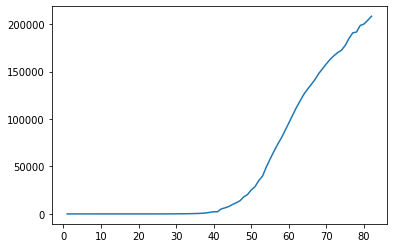

In [114]:
plt.plot(xspain,yspain)
plot.plot(RES[:,1])

In [115]:
RES

array([[ 4.67502370e+07,  1.00000000e+00,  0.00000000e+00],
       [-1.04569593e-11,  2.20532700e+05,  4.65297053e+07],
       [            nan,             nan,             nan],
       [            nan,             nan,             nan],
       [            nan,             nan,             nan],
       [            nan,             nan,             nan],
       [            nan,             nan,             nan],
       [            nan,             nan,             nan],
       [            nan,             nan,             nan],
       [            nan,             nan,             nan],
       [            nan,             nan,             nan],
       [            nan,             nan,             nan],
       [            nan,             nan,             nan],
       [            nan,             nan,             nan],
       [            nan,             nan,             nan],
       [            nan,             nan,             nan],
       [            nan,             nan

In [107]:
np.arange(1,len(spain['ConfirmedCases'])+1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82])

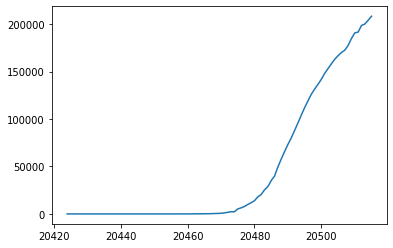

In [101]:
plt.plot(spain['ConfirmedCases'])
# plt.plot(RES[:,1])

In [16]:
country_df['ConfirmedCases'] = train.loc[train['Country_Region']=='Spain'].ConfirmedCases.diff().fillna(0)
country_df

,ConfirmedCases
20424,0.0
20425,0.0
20426,0.0
20427,0.0
20428,0.0
...,...
20511,887.0
20512,6948.0
20513,1536.0
20514,3968.0


In [18]:
country_df.head(11)

,ConfirmedCases
20424,0.0
20425,0.0
20426,0.0
20427,0.0
20428,0.0
20429,0.0
20430,0.0
20431,0.0
20432,0.0
20433,0.0


In [19]:
country_df = country_df[10:]
country_df

,ConfirmedCases
20434,1.0
20435,0.0
20436,0.0
20437,0.0
20438,0.0
...,...
20511,887.0
20512,6948.0
20513,1536.0
20514,3968.0


In [148]:
# list(range(1,len(country_df)+1))

In [21]:
country_df['day_count'] = list(range(1,len(country_df)+1))
country_df

,ConfirmedCases,day_count
20434,1.0,1
20435,0.0,2
20436,0.0,3
20437,0.0,4
20438,0.0,5
...,...,...
20511,887.0,78
20512,6948.0,79
20513,1536.0,80
20514,3968.0,81


In [24]:
ydata = [i for i in country_df.ConfirmedCases]
xdata = country_df.day_count
ydata = np.array(ydata, dtype=float)
xdata = np.array(xdata, dtype=float)

In [25]:
ydata

array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       4.000e+00, 7.000e+00, 2.000e+00, 1.700e+01, 1.300e+01, 3.900e+01,
       3.600e+01, 4.500e+01, 5.700e+01, 3.700e+01, 1.410e+02, 1.000e+02,
       1.730e+02, 4.000e+02, 6.220e+02, 5.820e+02, 0.000e+00, 2.955e+03,
       1.159e+03, 1.407e+03, 2.144e+03, 1.806e+03, 2.162e+03, 4.053e+03,
       2.447e+03, 4.964e+03, 3.394e+03, 6.368e+03, 4.749e+03, 9.630e+03,
       8.271e+03, 7.933e+03, 7.516e+03, 6.875e+03, 7.846e+03, 7.967e+03,
       8.195e+03, 7.947e+03, 7.134e+03, 6.969e+03, 5.478e+03, 5.029e+03,
       5.267e+03, 6.278e+03, 5.002e+03, 5.051e+03, 4.754e+03, 3.804e+03,
       3.268e+03, 2.442e+03, 5.103e+03, 7.304e+03, 5.891e+03, 8.870e+02,
       6.948e+03, 1.536e+03, 3.968e+03, 4.211e+03])

In [26]:
xdata

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65.,
       66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77., 78.,
       79., 80., 81., 82.])

In [27]:
population = float(46750238)
N = population
inf0 = ydata[0]
sus0 = N - inf0
rec0 = 0.0

print(N)
print(inf0)
print(sus0)
print(rec0)

46750238.0
1.0
46750237.0
0.0


In [28]:
def sir_model(y, x, beta, gamma):
    sus = -beta * y[0] * y[1] / N
    rec = gamma * y[1]
    inf = -(sus + rec)
    return sus, inf, rec

In [140]:
def fit_odeint(x, beta, gamma):
    sol = integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]
    return sol

In [31]:
print(fit_odeint)

<function fit_odeint at 0x000001E8DCAE1A68>


In [49]:
def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]


In [139]:
def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))
popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)

ValueError: operands could not be broadcast together with shapes (82,3) (82,) 

In [147]:
print(popt, pcov)
print('-------------')
print(popt)
print('-------------')
print( pcov)

[9.17665296 9.00343328] [[0.02697093 0.02698823]
 [0.02698823 0.02700854]]
-------------
[9.17665296 9.00343328]
-------------
[[0.02697093 0.02698823]
 [0.02698823 0.02700854]]


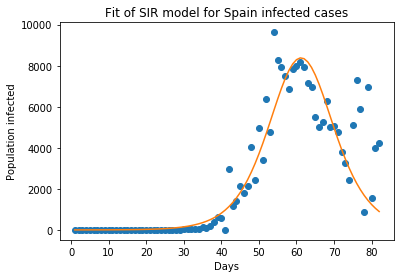

Optimal parameters: beta = 9.176652957185043  and gamma =  9.003433281361207


In [50]:
popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata, *popt)

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.title("Fit of SIR model for Spain infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

In [ ]:
def SIR(N, b0, beta, gamma, hs):
    
    """
    N = total number of population
    beta = transition rate S->I
    gamma = transition rate I->R
    k =  denotes the constant degree distribution of the network (average value for networks in which 
    the probability of finding a node with a different connectivity decays exponentially fast
    hs = jump step of the numerical integration
    """
    
    # Initial condition
    a = float(N-1)/N -b0
    b = float(1)/N +b0
    c = 0.

    sus, inf, rec= [],[],[]
    for i in range(10000): # Run for a certain number of time-steps
        sus.append(a)
        inf.append(b)
        rec.append(c)
        a,b,c = rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs)

    return sus, inf, rec

In [ ]:
# Parameters of the model
N = 7800*(10**6)
b0 = 0
beta = 0.7
gamma = 0.2
hs = 0.1

sus, inf, rec = SIR(N, b0, beta, gamma, hs)

f = plt.figure(figsize=(8,5)) 
plt.plot(sus, 'b.', label='susceptible');
plt.plot(inf, 'r.', label='infected');
plt.plot(rec, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,1000)
plt.savefig('SIR_example.png')
plt.show()

In [69]:
import scipy.integrate as spi
import numpy as np
import pylab as pl
%matplotlib inline

In [85]:
# beta=1.4247
# gamma=0.14286
###########################
beta=popt[0]
gamma=popt[1]
I0 = ydata[0]
S0 = N - I0
# rec0 = 0.0

print(I0, S0)
#############################
TS=1.0
ND=70.0
# S0=1-1e-6
# I0=1e-6
INPUT = (S0, I0, 0.0)

1.0 46750237.0


In [86]:
def diff_eqs(INP,t):  
	'''The main set of equations'''
	Y=np.zeros((3))
	V = INP    
	Y[0] = - beta * V[0] * V[1]
	Y[1] = beta * V[0] * V[1] - gamma * V[1]
	Y[2] = gamma * V[1]
	return Y   # For odeint

In [87]:
t_start = 0.0; t_end = ND; t_inc = TS
t_range = np.arange(t_start, t_end+t_inc, t_inc)
RES = spi.odeint(diff_eqs,INPUT,t_range)

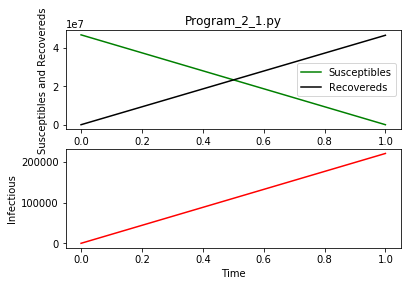

In [88]:
#Ploting
pl.subplot(211)
pl.plot(RES[:,0], '-g', label='Susceptibles')
pl.plot(RES[:,2], '-k', label='Recovereds')
pl.legend(loc=0)
pl.title('Program_2_1.py')
pl.xlabel('Time')
pl.ylabel('Susceptibles and Recovereds')
pl.subplot(212)
pl.plot(RES[:,1], '-r', label='Infectious')
pl.xlabel('Time')
pl.ylabel('Infectious')
pl.show()

In [136]:
# b = beta and k = gamma


from scipy.integrate import odeint
def SIR(y, t, N,b,k):
    S,I,R = y
    dS = -b*S*I
    dI = b*S*I - k*I
    dR = k*I
    return dS, dI, dR

n=46750238
si = n-i0
i0=1
r0=0
t = np.arange(90)
ic = s0, i0, r0
b = popt[0]
k =popt[1]
b = 0.0003
k =0.005

ret = odeint(SIR, ic, t, args=(n, b, k))
S, I, R = ret.T

In [137]:
I

array([1.00000000e+00, 4.65173641e+07, 4.62853578e+07, 4.60545086e+07,
       4.58248108e+07, 4.55962586e+07, 4.53688463e+07, 4.51425682e+07,
       4.49174187e+07, 4.46933922e+07, 4.44704829e+07, 4.42486855e+07,
       4.40279942e+07, 4.38084037e+07, 4.35899084e+07, 4.33725028e+07,
       4.31561815e+07, 4.29409392e+07, 4.27267704e+07, 4.25136697e+07,
       4.23016319e+07, 4.20906516e+07, 4.18807236e+07, 4.16718426e+07,
       4.14640034e+07, 4.12572009e+07, 4.10514297e+07, 4.08466849e+07,
       4.06429612e+07, 4.04402536e+07, 4.02385570e+07, 4.00378663e+07,
       3.98381766e+07, 3.96394829e+07, 3.94417801e+07, 3.92450634e+07,
       3.90493279e+07, 3.88545685e+07, 3.86607806e+07, 3.84679591e+07,
       3.82760994e+07, 3.80851965e+07, 3.78952458e+07, 3.77062425e+07,
       3.75181818e+07, 3.73310591e+07, 3.71448697e+07, 3.69596089e+07,
       3.67752721e+07, 3.65918546e+07, 3.64093520e+07, 3.62277596e+07,
       3.60470729e+07, 3.58672874e+07, 3.56883985e+07, 3.55104019e+07,
      

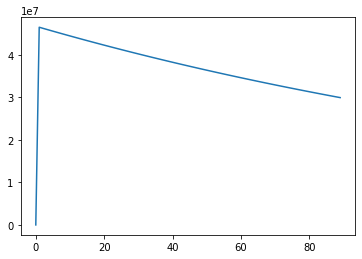

In [138]:
plt.plot(t,I)

In [128]:
# Ordinary differential equation of SEIR
def ODE_SEIR(y, t, N, beta, Tinc, Tinf):
    S, E, I, R = y
    dSdt = -(beta*I*S/N)
    dEdt = (beta*I*S/N) - (E/Tinc)
    dIdt = (E/Tinc) - (I/Tinf)
    dRdt = I/Tinf
    return dSdt, dEdt, dIdt, dRdt

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89])

In [41]:
fitted = fit_odeint(xdata, *popt)

In [43]:
xdata

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65.,
       66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77., 78.,
       79., 80., 81., 82.])

In [47]:
print(fitted.shape)

(82, 3)


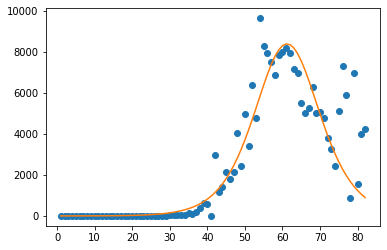

In [52]:
plt.plot(xdata, ydata, 'o')

plt.plot(xdata, fitted)

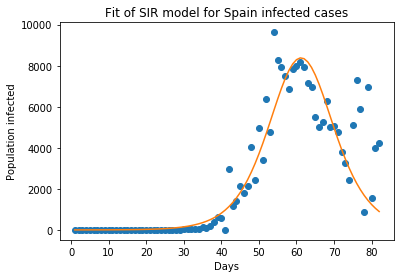

Optimal parameters: beta = 9.176652957185043  and gamma =  9.003433281361207


In [155]:
population = float(46750238)

# สร้าง data frame ใหม่
country_df = pd.DataFrame()

# ใส่ข้อมูลเฉพาะประเทศ Spain โดยเงื่อนไข ของผลต่าง (diff) และ แปลง non เป็น 0
country_df['ConfirmedCases'] = train.loc[train['Country_Region']=='Spain'].ConfirmedCases.diff().fillna(0)

# เอาเฉพาะข้อมูลที่มีเลข diff ตัวแรก
country_df = country_df[10:]

# สร้าง indax ให้ข้อมูล
country_df['day_count'] = list(range(1,len(country_df)+1))

# แปลงข้อมูลให้อยู่ในรูปแบบ array
ydata = [i for i in country_df.ConfirmedCases]
xdata = country_df.day_count
ydata = np.array(ydata, dtype=float)
xdata = np.array(xdata, dtype=float)

N = population

# initial condtion
inf0 = ydata[0]
sus0 = N - inf0
rec0 = 0.0

def sir_model(y, x, beta, gamma):
    sus = -beta * y[0] * y[1] / N
    rec = gamma * y[1]
    inf = -(sus + rec)
    return sus, inf, rec

def fit_odeint(x, beta, gamma):
#      return integrate.solve_ivp(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]


popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata, *popt)

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.title("Fit of SIR model for Spain infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

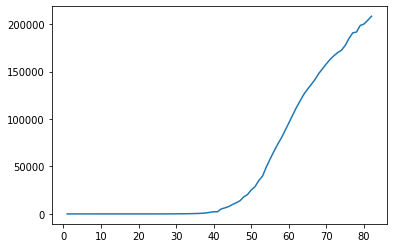

In [234]:
plt.plot(xspain,yspain)
# plt.plot(xdata, fitted)

In [181]:
def sir_model_sol(y, x, beta, gamma):
    S,R,I = y
    dsdt = -beta * S *I / N
    didt = gamma * I/N - gamma*I
    drdt = gamma*I
    return dsdt, didt, drdt


bete_con = popt[0]
gamma_con = popt[1]

N ,sus0, inf0, rec0 = 10000, 99910, 10,0
# yi = Si, Ei, Ii, Ri
# def fit_odeint(x, beta, gamma):
rec = integrate.odeint(sir_model_sol, (sus0, inf0, rec0), xdata, args=(beta, gamma))

In [182]:
rec.T.shape

(3, 82)

In [185]:
rec

array([[9.991e+04, 1.000e+01, 0.000e+00],
       [9.991e+04, 1.000e+01, 0.000e+00],
       [9.991e+04, 1.000e+01, 0.000e+00],
       [9.991e+04, 1.000e+01, 0.000e+00],
       [9.991e+04, 1.000e+01, 0.000e+00],
       [9.991e+04, 1.000e+01, 0.000e+00],
       [9.991e+04, 1.000e+01, 0.000e+00],
       [9.991e+04, 1.000e+01, 0.000e+00],
       [9.991e+04, 1.000e+01, 0.000e+00],
       [9.991e+04, 1.000e+01, 0.000e+00],
       [9.991e+04, 1.000e+01, 0.000e+00],
       [9.991e+04, 1.000e+01, 0.000e+00],
       [9.991e+04, 1.000e+01, 0.000e+00],
       [9.991e+04, 1.000e+01, 0.000e+00],
       [9.991e+04, 1.000e+01, 0.000e+00],
       [9.991e+04, 1.000e+01, 0.000e+00],
       [9.991e+04, 1.000e+01, 0.000e+00],
       [9.991e+04, 1.000e+01, 0.000e+00],
       [9.991e+04, 1.000e+01, 0.000e+00],
       [9.991e+04, 1.000e+01, 0.000e+00],
       [9.991e+04, 1.000e+01, 0.000e+00],
       [9.991e+04, 1.000e+01, 0.000e+00],
       [9.991e+04, 1.000e+01, 0.000e+00],
       [9.991e+04, 1.000e+01, 0.00

In [240]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total population, N.
N = 46750238
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 2, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
# beta, gamma = 0.2, 1./10 
beta, gamma = 0.373 , 0.4273
# A grid of time points (in days)
t = np.linspace(0, 180,180)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I /N
    dIdt = beta * S * I /N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T


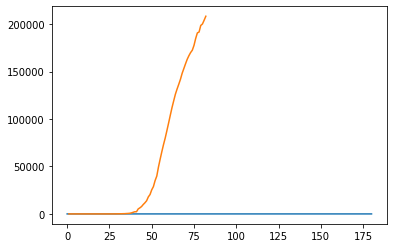

In [241]:
# plt.plot(t,S)
plt.plot(t,I)
# plt.plot(t,R)
plt.plot(xspain,yspain)

In [196]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axis_bgcolor='#dddddd', axisbelow=True)
ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

AttributeError: 'AxesSubplot' object has no property 'axis_bgcolor'

<Figure size 432x288 with 0 Axes>

In [207]:
I

array([1.00000000e+000, 2.20426268e+005, 1.03737767e-311, 1.03737767e-311,
       1.03737761e-311, 1.03737767e-311, 1.03737767e-311, 1.03737767e-311,
       1.03737767e-311, 1.03737766e-311, 1.03737766e-311, 1.03737766e-311,
       1.03737766e-311, 1.03737766e-311, 1.03737766e-311, 1.03737766e-311,
       1.03737766e-311, 1.03737766e-311, 1.03737766e-311, 1.03737766e-311,
       1.03737766e-311, 1.03737766e-311, 1.03737766e-311, 1.03737766e-311,
       1.03737766e-311, 1.03737766e-311, 1.03737766e-311, 1.03737766e-311,
       1.03737766e-311, 1.03737766e-311, 1.03737766e-311, 1.03737766e-311,
       1.03737766e-311, 1.03737766e-311, 1.03737766e-311, 1.03737766e-311,
       1.03737766e-311, 1.03737766e-311, 1.03737766e-311, 1.03737766e-311,
       1.03737766e-311, 1.03737766e-311, 1.03737766e-311, 1.03737766e-311,
       1.03737725e-311, 1.03737765e-311, 1.03737765e-311, 1.03737765e-311,
       1.03737765e-311, 1.03737765e-311, 1.03737765e-311, 1.03737765e-311,
       1.03737765e-311, 1

In [170]:
print(sus0, inf0, rec0 )

46750237.0 1.0 0.0


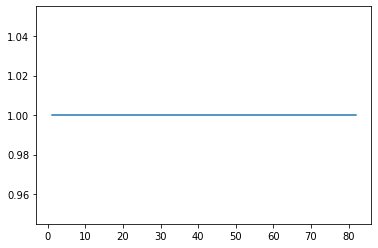

In [171]:
plt.plot(xdata,rec.T)

In [ ]:
country_df['ConfirmedCases'] = train.loc[train['Country_Region']=='Spain'].ConfirmedCases.diff().fillna(0)

In [ ]:
country_df['ConfirmedCases'] = train.loc[train['Country_Region']=='Spain']

In [ ]:
country_df